In [2]:
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [186]:

deltas = 1 / jnp.array([16,32, 64, 128, 256, 512, 1024])
Ns = 1/deltas
fineN = Ns**1.0
Mdeltas = jnp.ones((len(deltas),)) * (Ns)**0.
T = 10
Ndeltas = T/deltas


folder = "./"
solver_name = "EKF0_SSM"
problem_name = "FHN"
prefix = f"{solver_name}_{problem_name}"
for n in range(len(Ndeltas)):
    delta = deltas[n]
    N = int(Ndeltas[n])
    M = int(Mdeltas[n])
    fine = int(fineN[n])
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}_{M}.npy')
    paths_2 = jnp.load(f'{folder}/EKF0_FHN_pathwise_sols2_{N}_{fine}.npy')
    N = int(N)
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, T, N)
    ranged = range(N)
    plt.plot(ts, jnp.log(jnp.mean(jnp.linalg.norm(paths_1 - paths_2, axis=-1), axis=0)) / jnp.log(delta),
             label=f'delta={delta}, M={M}')
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: './/EKF0_FHN_pathwise_sols2_16_16.npy'

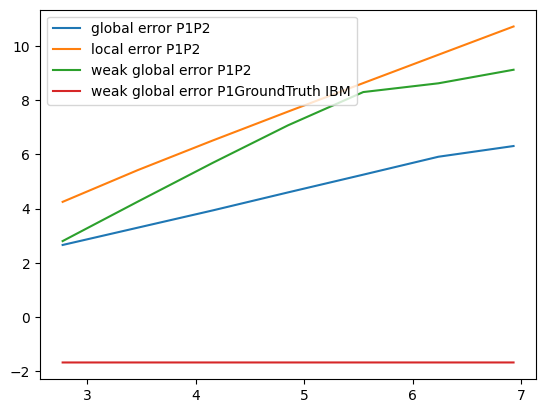

In [183]:
STRONG_GLOBAL_ERRORS_P1P2 = []
STRONG_LOCAL_ERRORS_P1P2 = []
WEAK_GLOBAL_ERRORS_P1P2 = []
WEAK_GLOBAL_ERRORS_P1GroundTruth = []
@partial(jnp.vectorize, signature="(d,x)->(d,d)")
def WEAK_POLYNOMIAL(x):
    return x @ x.T


COV_HYPOELLIPTIC_COMPONENT_ERRORS = []
for n in range(len(deltas)):
    N = int(Ndeltas[n])
    M = int(Mdeltas[n])
    fine = int(fineN[n])
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}_{M}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}_{fine}.npy')
    #paths = jnp.load(f'{folder}/{prefix}_paths_{N}_{fine}.npy')
    STRONG_GLOBAL_ERROR_P1P2 = jnp.mean(jnp.linalg.norm(paths_2 - paths_1, axis=-1), axis=0)[-1]
    STRONG_LOCAL_ERROR_P1P2 = jnp.mean(jnp.linalg.norm(paths_2[:, 1] - paths_1[:, 1], axis=-1), axis=0)
    
    MOMENT_P1 = WEAK_POLYNOMIAL(paths_1[...,jnp.newaxis])
    MOMENT_P2 = WEAK_POLYNOMIAL(paths_2[...,jnp.newaxis])
    
    WEAK_GLOBAL_ERROR_P1P2 = jnp.max(jnp.linalg.norm(jnp.linalg.norm(jnp.mean(MOMENT_P2, axis=0)-jnp.mean(MOMENT_P1, axis=0),axis=-1),axis=-1),axis=-1)
    STRONG_GLOBAL_ERRORS_P1P2.append(STRONG_GLOBAL_ERROR_P1P2)
    STRONG_LOCAL_ERRORS_P1P2.append(STRONG_LOCAL_ERROR_P1P2)
    WEAK_GLOBAL_ERRORS_P1P2.append(WEAK_GLOBAL_ERROR_P1P2)
    
    #ONLY FOR IBM
    WEAK_GLOBAL_ERROR_P1GroundTruth = jnp.linalg.norm(jnp.linalg.norm(jnp.mean(MOMENT_P1[:,-1,:], axis=0)-jnp.array([[4+1/3, 2+1/2],                                                            [2+1/2, 1+1]]),axis=-1),axis=-1)
    WEAK_GLOBAL_ERRORS_P1GroundTruth.append(WEAK_GLOBAL_ERROR_P1GroundTruth)
STRONG_GLOBAL_ERRORS_P1P2 = jnp.array(STRONG_GLOBAL_ERRORS_P1P2)
STRONG_LOCAL_ERRORS_P1P2 = jnp.array(STRONG_LOCAL_ERRORS_P1P2)
WEAK_GLOBAL_ERRORS_P1P2 = jnp.array(WEAK_GLOBAL_ERRORS_P1P2)
WEAK_GLOBAL_ERRORS_P1GroundTruth = jnp.array(WEAK_GLOBAL_ERRORS_P1GroundTruth)
plt.plot(-jnp.log(deltas), -jnp.log(STRONG_GLOBAL_ERRORS_P1P2), label='global error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(STRONG_LOCAL_ERRORS_P1P2), label='local error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(WEAK_GLOBAL_ERRORS_P1P2), label='weak global error P1P2')
plt.plot(-jnp.log(deltas), -jnp.log(WEAK_GLOBAL_ERRORS_P1GroundTruth), label='weak global error P1GroundTruth IBM')
plt.legend()

In [184]:
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_GLOBAL_ERRORS_P1P2))
print(linear_regressor.coef_)
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(STRONG_LOCAL_ERRORS_P1P2))
print(linear_regressor.coef_)
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(WEAK_GLOBAL_ERRORS_P1P2))
print(linear_regressor.coef_)
linear_regressor = LinearRegression().fit(-jnp.log(deltas)[:-4].reshape(-1, 1), -jnp.log(WEAK_GLOBAL_ERRORS_P1GroundTruth[:-4]))
print(linear_regressor.coef_)


[0.90094346]
[1.546287]
[1.5598494]
[0.00028635]


In [12]:
jnp.save(f'{prefix}_STRONG_GLOBAL_ERRORS', jnp.array([deltas, STRONG_GLOBAL_ERRORS_P1P2]))
jnp.save(f'{prefix}_STRONG_LOCAL_ERRORS', jnp.array([deltas, STRONG_LOCAL_ERRORS_P1P2]))
jnp.save(f'{prefix}_WEAK_GLOBAL_ERRORS', jnp.array([deltas, WEAK_GLOBAL_ERRORS_P1P2]))
#jnp.save(f'{prefix}_WEAK_GLOBAL_ERRORS_P1GroundTruth', jnp.array([deltas, WEAK_GLOBAL_ERRORS_P1GroundTruth]))

In [13]:
STRONG_GLOBAL_ERRORS = jnp.load(f'{prefix}_STRONG_GLOBAL_ERRORS.npy')
STRONG_LOCAL_ERRORS = jnp.load(f'{prefix}_STRONG_LOCAL_ERRORS.npy')
WEAK_GLOBAL_ERRORS = jnp.load(f'{prefix}_WEAK_GLOBAL_ERRORS.npy')
#WEAK_GLOBAL_ERRORS_P1GroundTruth = jnp.load(f'{prefix}_WEAK_GLOBAL_ERRORS_P1GroundTruth.npy')

np.savetxt(f'{prefix}_STRONG_GLOBAL_ERRORS.csv', STRONG_GLOBAL_ERRORS.T, delimiter=',', header='deltas,errors', comments="")
np.savetxt(f'{prefix}_STRONG_LOCAL_ERRORS.csv', STRONG_LOCAL_ERRORS.T, delimiter=',', header='deltas,errors', comments="")
np.savetxt(f'{prefix}_WEAK_GLOBAL_ERRORS.csv', WEAK_GLOBAL_ERRORS.T, delimiter=',', header='deltas,errors', comments="")
#np.savetxt(f'{prefix}_WEAK_GLOBAL_ERRORS_P1GroundTruth.csv', WEAK_GLOBAL_ERRORS_P1GroundTruth.T, delimiter=',', header='deltas,errors', comments="")

In [48]:
deltas = [0.1, 0.05, 0.025, 0.01]
LOCAL_ERRORS = []
for delta in deltas:
    experiment_local = jnp.load(f'./experiment_{delta}.npy')
    LOCAL_ERRORS.append(jnp.mean(jnp.linalg.norm(experiment_local[0] - experiment_local[1], axis=-1), axis=0))
LOCAL_ERRORS = jnp.array(LOCAL_ERRORS)
deltas = jnp.array(deltas)
plt.plot(-jnp.log(deltas), -jnp.log(LOCAL_ERRORS))

FileNotFoundError: [Errno 2] No such file or directory: './experiment_0.1.npy'

In [114]:
test2 = jnp.load('./EKF0_SSM_FHN_pathwise_sols_256_1.npy')

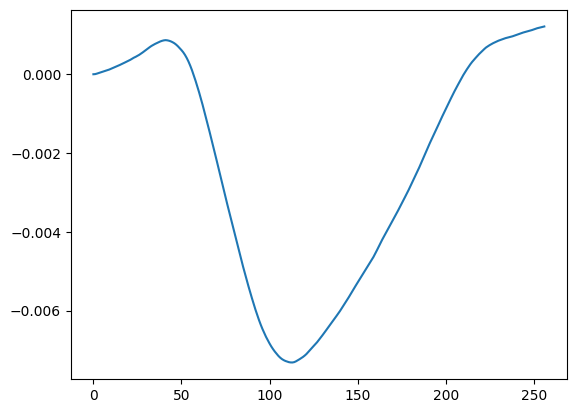

In [128]:
plt.plot(jnp.mean(test2[:, :1024,0], axis=0)-jnp.mean(test[:, :1025,0][:,::4], axis=0))

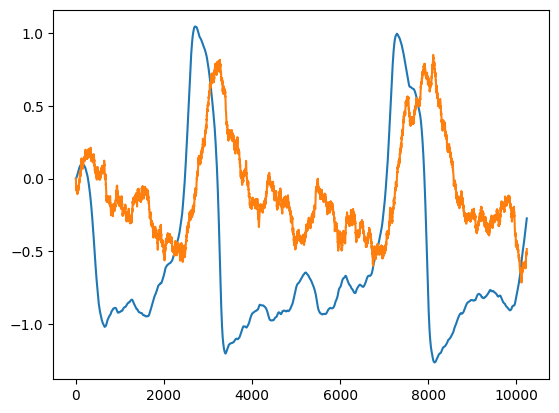

In [10]:
plt.plot(paths_1[10])

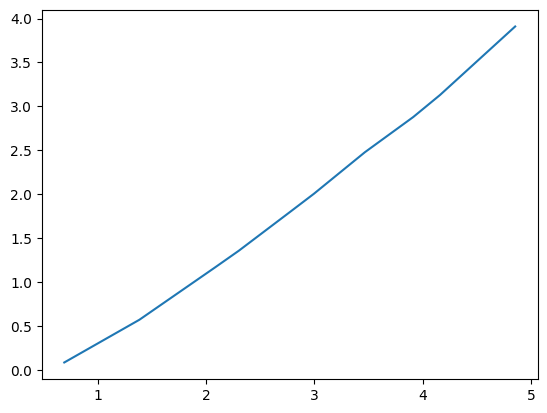

In [174]:
plt.plot(-jnp.log(deltas), -jnp.log(WEAK_GLOBAL_ERRORS_P1GroundTruth))

In [176]:
linear_regressor = LinearRegression().fit(-jnp.log(deltas).reshape(-1, 1), -jnp.log(WEAK_GLOBAL_ERRORS_P1GroundTruth))
print(linear_regressor.coef_)

[0.9219163]
